<br>
<img src="https://cdn.slidesharecdn.com/ss_thumbnails/netflixprize-170320014819-thumbnail-4.jpg?cb=1489978383" width='25%'>
<h1 align='center'> Netflix Prize Challenge - Movie Recommendation </h1>
<h2 align='center'> <font color='#FC7307'> Deep Learning </font> </h2>
<h3 align='center'>  Wenyi Hu </h3>
<br>

## <a name='#toc'></a> Table of Contents

1. [Import Libraries](#1.-Import-Libraries)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Build Model Architecture](#3.-Build-Keras-Model-Architecture)
4. [Train Model](#4.-Train-Model)
5. [Model Evaluation](#5.-Model-Evaluation)

# 1. Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os

# for ploting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True) 

# for data preprocessing
from sklearn.preprocessing import LabelEncoder

# import model validation method
from sklearn.model_selection import train_test_split

# imports for deep learning
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Concatenate, Dense, Dropout, Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

# 2. Data Preprocessing

In [2]:
# Read all data into a pd dataframe
data = pd.read_csv('data.csv', names=['movie_id', 'user_id', 'rating', 'date'])

# Convert date to datetime type
data['date'] = pd.to_datetime(data['date'])

print(data.nunique())

movie_id     17770
user_id     480189
rating           5
date          2182
dtype: int64


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   movie_id  int64         
 1   user_id   int64         
 2   rating    int64         
 3   date      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.0 GB


In [4]:
data.isnull().sum()

movie_id    0
user_id     0
rating      0
date        0
dtype: int64

In [5]:
data.describe()

,movie_id,user_id,rating
count,1.004805e+08,1.004805e+08,1.004805e+08
mean,9.070915e+03,1.322489e+06,3.604290e+00
std,5.131891e+03,7.645368e+05,1.085219e+00
min,1.000000e+00,6.000000e+00,1.000000e+00
25%,4.677000e+03,6.611980e+05,3.000000e+00
50%,9.051000e+03,1.319012e+06,4.000000e+00
75%,1.363500e+04,1.984455e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


A smaller dataset (users gave the most rates on most movies) is chosen for the project, with 1000 top rated movies and 10,000 top users. The 12% of the ratings are retained from the whole records.

In [6]:
df = pd.DataFrame()

group = data.groupby('user_id')['rating'].count().rename('user_rating_cnt')
top_users = group.sort_values(ascending=False)[:10000]

group = data.groupby('movie_id')['rating'].count().rename('movie_rating_cnt')
top_movies = group.sort_values(ascending=False)[:1000]

df = data.join(top_users, how='inner', on='user_id')
df = df.join(top_movies, how='inner', on='movie_id')

df.reset_index(drop=True, inplace=True)

Re-name the users and movies for uniform name from 0 to 10000 and 1000 respectively

In [7]:
enc = LabelEncoder()
df['user_id'] = enc.fit_transform(df['user_id'].values)
df['movie_id'] = enc.fit_transform(df['movie_id'].values)
#df.to_csv('top_rating_df.csv', header = True, index = False)

In [8]:
# Check the number of movies and users
n_movies = df['movie_id'].nunique()
n_users = df['user_id'].nunique()

print('The number of movies is:',n_movies)
print('The number of users is',n_users)
print('The size (rows) of data processed is',len(df))

The number of movies is: 1000
The number of users is 10000
The size (rows) of data processed is 6264018


Select only 'user' and 'movie' to do deep learning, and convert X, y to np.array

In [9]:
X = df[['user_id', 'movie_id']].values
y = df['rating'].values

Train/Test Sets Preparation

In [10]:
# Split train and test data (for test model performance at last)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# 3. Build Keras Model Architecture

In [11]:
# Set the embedding dimension of Matrix factorization
e_dimension = 200 # was 50

# Build user and movie embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(user) # embedding was 1e-6
u = Reshape((e_dimension,))(u)

movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-7))(movie)  # embedding was 1e-6
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])

# concat user, movie along with dot
x = Concatenate()([u, m, x])

x = Dropout(0.2)(x)

# Build last deep learning layers 
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=Adam(lr=0.001),  ## 0.003
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

# Print model info summary
model.summary()  

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       2000000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       200000      ['input_2[0][0]']                
                                                                                              

D:\Wangke\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## 4. Train Model

In [12]:
%%time
history = model.fit(x=X_train_array, y=y_train, batch_size=64,
                    epochs=10, # 20
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )

# Save the model (we should make a good habit of always saving our models after training)
model.save("Model_1")

Epoch 1/10
79279/79279 [==============================] - 919s 12ms/step - loss: 0.7988 - root_mean_squared_error: 0.8906 - val_loss: 0.7216 - val_root_mean_squared_error: 0.8429
Epoch 2/10
79279/79279 [==============================] - 936s 12ms/step - loss: 0.7139 - root_mean_squared_error: 0.8356 - val_loss: 0.6898 - val_root_mean_squared_error: 0.8187
Epoch 3/10
79279/79279 [==============================] - 995s 13ms/step - loss: 0.6778 - root_mean_squared_error: 0.8092 - val_loss: 0.6723 - val_root_mean_squared_error: 0.8039
Epoch 4/10
79279/79279 [==============================] - 1061s 13ms/step - loss: 0.6383 - root_mean_squared_error: 0.7806 - val_loss: 0.6726 - val_root_mean_squared_error: 0.8006
INFO:tensorflow:Assets written to: Model_1\assets
CPU times: total: 7h 36min 38s
Wall time: 1h 5min 11s


Visualize the training and validation loss

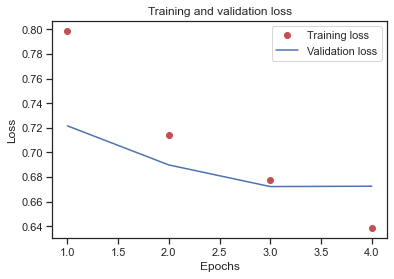

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Model Evaluation

In [14]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

19576/19576 [==============================] - 11s 546us/step


0.8004348